# SUPPORT VECTOR MACHINES

In [1]:
% pylab inline
% config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd

import seaborn as sns
from sklearn import datasets, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report

In [3]:
# pulling in our iris dataset for a quick viz
iris = datasets.load_iris()
X = iris.data
y = iris.target
# lets grab 1st 2 classes first,
set0 = X[y == 0, :2]
set1 = X[y == 1, :2]

## How would the ideal classifier split the classes of this dataset?

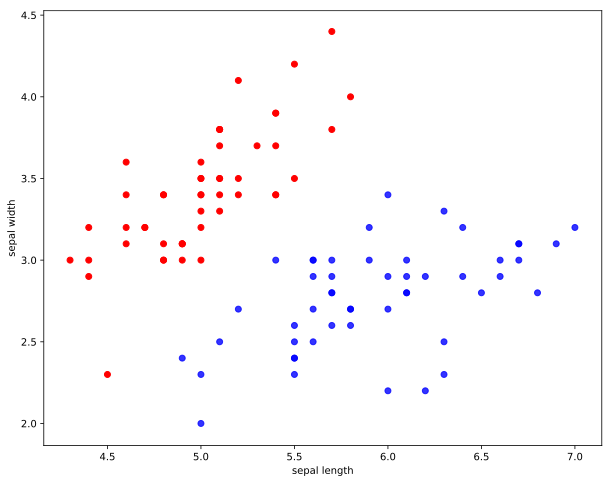

In [4]:
plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(set0[:, 0], set0[:, 1], c='r')
plt.scatter(set1[:, 0], set1[:, 1], c='b', alpha=.8)
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.show()

## How would the ideal classifier split the classes of *this* dataset?

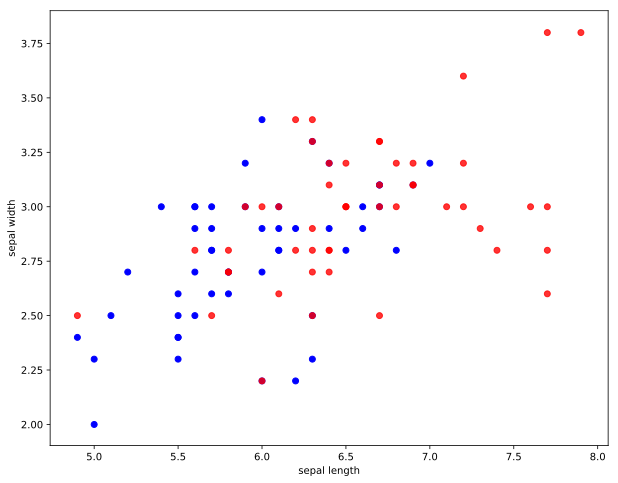

In [5]:
# lets grab 2nd 2 classes,
set1 = X[y == 1, :2]
set2 = X[y == 2, :2]
plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(set1[:, 0], set1[:, 1], c='b')
plt.scatter(set2[:, 0], set2[:, 1], c='r', alpha=.8)
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.show()

### Lets take a step back and refresh our Logistic Regression Memory

Recall that with logistic regression, we are leveraging the **sigmoid function + a decision rule**

Our decision rule is a simple one.    
If p > 0.5  → predict y =1 (positive)    
If p < 0.5  → predict y = 0 (negative)


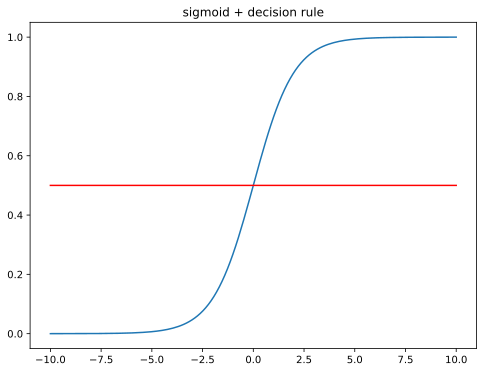

In [6]:
# lets view sigmoid + decision rule !
def sigmoid(z):
    '''
    Quick sigmoid function w/
    input z: linear combination of features
    '''
    return(1/(1+np.exp(-z)))
x = np.linspace(-10, 10, 150)
y = [sigmoid(s) for s in x]
y2 = [.5 for x in x]
plt.figure(figsize=(8, 6))
plt.plot(x, y)
plt.plot(x, y2, c='r')
plt.title('sigmoid + decision rule')
plt.show()

In [7]:
# a function for viewing the decision boundary
def plot_estimator(estimator, X, y, annot=True, color=None):
    """
    create a plot to view decision boundary of classifier
    Parameters:
    -----------
    esimator: classifier used to create the model
    X: test-data, first two dimensions of which will be used for plotting
    y: test labels
    annot: boolean, whether to annotate observations
    color: define cmaps color
    """
    estimator.fit(X, y)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Put the result into a color plot
    plt.figure(figsize=(12, 12))
    plt.pcolormesh(xx, yy, Z, cmap=color, alpha=.7)
    plt.xlim(4.5)
    plt.ylim(2)
    # Lets plot our sample points
    plt.scatter(X[:, 0], X[:, 1], c=y)
    if annot:
        predicts = estimator.predict_proba(X)
        for i, txt in enumerate(predicts[:, 1]):
            plt.annotate(np.round(txt, decimals=2),
                         (X[:, 0][i]+.02, X[:, 1][i]+.02), fontsize=12)

### Logistic Regression Decision Boundary 
Here we developed a LR decision boundary (w/ linearly separable data)



In [8]:
# get iris data & labels,
X = iris.data
y = iris.target
# grabbing 1st two classes,
X_sep = X[y != 2, :2]
y_sep = iris.target[y != 2]
# instantiate model 
lr = LogisticRegression()
# plot the LR decision boundary
plot_estimator(lr, X_sep, y_sep, color='Blues_r')

### What do you notice?

We notice that the further away observations are from the decision boundary, the 
more confident the LR model is what its predictions.

**SVMs take this notion one step further.**



###  What about the SVM decision boundary? 

In [9]:
# develop a quick model via sklearn's SVC classifier class.
svm = LinearSVC()
# plot the LR decision boundary
plot_estimator(svm, X_sep, y_sep, annot=False, color='RdBu')

### Looks similiar to Logistic Regression 

Does SVM behave similiarly to Logistic Regresson? 

Well, **it depends**. 
The answer to that question is directly *hinged* to which 
*cost function* you are using (no pun intended)

**And SVMs have many of them!**

<img src='data/losses.png'>




# Linear SVMS 
## HARD MARGIN

Let’s begin with the notion of linearly separable data & Hard Margin cost function.

Let's start by repeating the quesion we asked earlier.    

**How would the ideal classifier split the dataset below?**

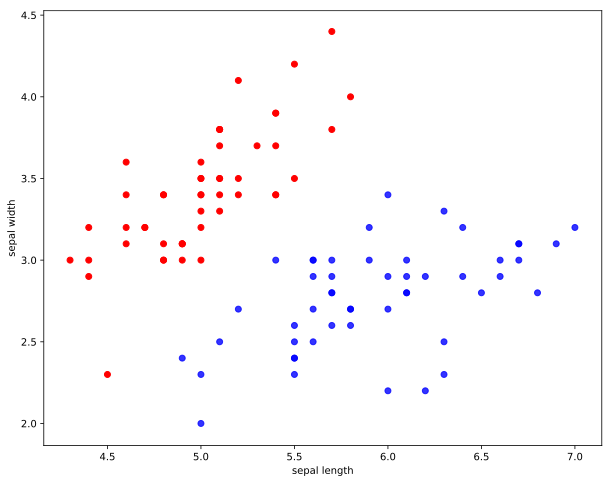

In [10]:
plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(set0[:, 0], set0[:, 1], c='r')
plt.scatter(set1[:, 0], set1[:, 1], c='b', alpha=.8)
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.show()

## Perhaps something like this?

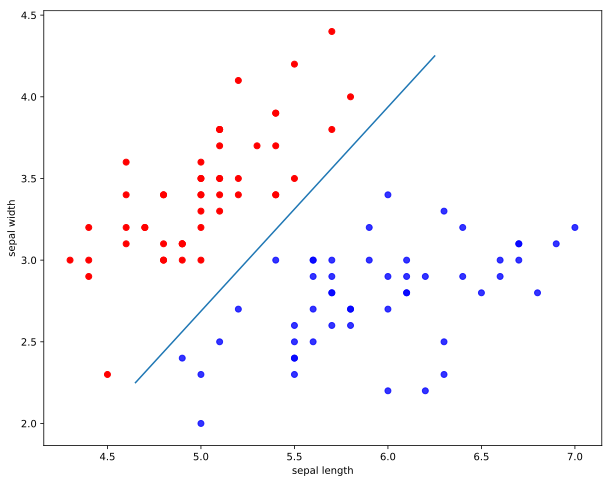

In [11]:
plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(set0[:, 0], set0[:, 1], c='r')
plt.scatter(set1[:, 0], set1[:, 1], c='b', alpha=.8)
plt.plot([4.65, 6.25], [2.25, 4.25])
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.show()

## Indeed!

When dealing with SVM Hard Margin approach, the correct decision 
boundary is the one that maximizes the distance between both classes. 

## How do we find the optimal decision boundary (aka hyperplane)?

Just like with other linear models: 
we solve for the weight vector that meets our objective     
(recall with OLS the objective was to solve for the weights that minimize residual error).  Same idea.

But with SVM (hard margin) : the objective is to simultaneously maximize the margin     
while ensuring that positive   classes & negative classes remain on opposite sides of the boundary. 

<img src='data/svm_hardmargin.png'>

### Lets solve for the optimal hyperplane: 

**Step 1) Develop constraints:**  
Let's start by forcing a separation between the different classes 

$f(x) = w_1x_1  + w_2x_2 +b$

f(x) >= +1 (for pos. samples)   
f(x) <= -1 (for negative samples)  

** Step 2) Compute the margin geometrically**   

$$ \vec{w}\cdot{{x_+}} + b = +1 $$
$$ \vec{w}\cdot{{x_-}} + b = -1 $$
$$ (\vec{w}\cdot{{x_+}}) -(\vec{w}\cdot{{x_-}})= 2 $$

$$width =({x}_{+}-{x}_{-})\cdot{{\vec{w}\above 1pt\|w\|}}={{2\above 1pt\|w\|}}$$

$$ Maximize {{2\above 1pt\|w\|}}$$
  
$$ Minimize  {{\|w\|^2\above 1pt 2}}$$

**Combining Steps 1 & 2 **:   
Solve for w: s.t. we are simulataneously  
minimimizing ${{\|w\|^2\above 1pt 2}}$ while using **n** equations (s.t)     

$f(x) = w_1x_1  + w_2x_2 +b > 1 $(for pos samples)   
$f(x) = w_1x_1  + w_2x_2 +b < 1 $(for neg samples)

This loss function is referred to the Hard Margin primal:  
and is a hefty constrained optimization problem.

So much so that sklearn does not really bother with this implementation.   
** Let's see how we can make this loss function a bit more managable**

##  Dual Solution

Going back to our optimization problem above:    
(recall from your calculus classes)   
 
#### (Q:) What can we do when:   

1) We have an equation we want to find the minima of    

2) But we also have constraints we need to honor? 

#### (A:) We want to **use Lagrangian Multipliers! ** 

<img src='https://upload.wikimedia.org/wikipedia/commons/b/bf/LagrangeMultipliers2D.svg', width=800,height=600>

### YES !!  

<img src='https://emojipedia-us.s3.dualstack.us-west-1.amazonaws.com/thumbs/120/google/146/clapping-hands-sign_1f44f.png', width=150,height=150>

** Let's use a cost function**  using equations from steps (1) & (2).    

We'll plug this into the Lagrange function: 
$L(x,y,\alpha) = f(x,y) - \alpha(g(x,y))$

$$ L=  1/2{{\|w\|}^2} - \sum \alpha_i[1- (y_i(\vec{w}\cdot{x_i} +b)] $$    


As usual we want to solve for the weight parameters that will minimize our loss function.     

**(Q)** How do we find the minima of the function above ? 


**(A)**  Partial Derviatives.


###  Right Again !! 
<img src='https://emojipedia-us.s3.dualstack.us-west-1.amazonaws.com/thumbs/120/google/146/clapping-hands-sign_1f44f.png', width=200,height=200>

We will take the partial derivative of the loss with respect to w (dL/dw).   

We can solve for w directly:    

$$\vec{w} = \sum \alpha_i({x_i})$$    

We can also solve for b directly    

$$ \sum \alpha_i(y_i)=0$$

We also have a constraint on alpha (s.t.) if   

$ 1- y_i(\vec{w}\cdot{x_i} +b) <= 0: $
then $a_i =0$ 

$ 1- y_i(\vec{w}\cdot{x_i} +b) >>  0$ , then $a_i => inf $    

Intuitively, this makes sense: if we meet the required constraint of the RH term of the loss function, 
then that term of the loss is 0,   
otherwise we have a cost to pay!

## COOL SVM FACT #1 
Any observtion $x_i$ that has a non-zero alpha (or point lying on the boundary )
is a support vector!

**Wrapping it up:**   
Let's plug the w & b terms into our loss function: 

$$ L= \sum \alpha_i -1/2\sum\sum\alpha_i\alpha_j(y_iy_j)(x_i\cdot{x_j})$$

1) Note that the second term of the loss function ends up being the pairwise dot product of observations.

What else??

2) Our Loss is only being affected by the support vector observations


**Hold these thoughts!  They are important, and we will come back to them shortly ** 


### We code :  Let's visualize our support vectors 

Let's add a bit of functionality to our existing plot_estimator function, using inspiration from sklearn:      
http://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html

But let's first break down the code we already have.
Stare at the code for a second.  
Be ready to explain what the code is doing. 

```
# lets add some code for the decision boundary and margins
xy = np.vstack([xx.ravel(), yy.ravel()]).T
Z= estimator.decision_function(xy).reshape(xx.shape)
plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
           
# plot support vectors
plt.scatter(estimator.support_vectors_[:, 0], estimator.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='r')
           
```
 
What is the decision_function doing?    
 

In [12]:
def plot_estimator_with_margin(estimator, X, y, annot=True, color=None):
    """
    create a plot to view decision boundary of classifier
    Parameters:
    -----------
    esimator: classifier used to create the model
    X: test-data, first two dimensions of which will be used for plotting
    y: test labels
    annot: boolean, whether to annotate observations
    color: define cmaps color
    """
    estimator.fit(X, y)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))         
    # Z= estimator.predict(np.c_[xx.ravel(), yy.ravel()])
    xy = np.vstack([xx.ravel(), yy.ravel()]).T
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ZZ = estimator.decision_function(xy).reshape(xx.shape)              
    # Put the result into a color plot
    plt.figure(figsize=(12, 12))
    plt.pcolormesh(xx, yy, Z, cmap=color, alpha=.7)
    plt.xlim(4)
    plt.ylim(2)
    # Lets plot our sample points
    plt.scatter(X[:, 0], X[:, 1], c=y)
    # plot decision boundary & margins
    plt.contour(xx, yy, ZZ, colors='k', levels=[-1, 0, 1], alpha=0.5,
                linestyles=['--', '-', '--'])
    # plot support vectors
    plt.scatter(estimator.support_vectors_[:, 0],
                estimator.support_vectors_[:, 1], s=100,
                linewidth=1, facecolors='r')
    if annot:
        predicts = estimator.predict_proba(x_train)
        for i, txt in enumerate(predicts[:, 1]):
            plt.annotate(np.round(txt, decimals=2), (X[:, 0][i] + .02,
                                    X[:, 1][i] + .02), fontsize=1)

In [13]:
# or for fun we can replace estimator.predict function with
# the estimator.decison_function for some pretty cool results!
def plot_estimator_with_margin_gradient(estimator, X, y, annot=True,
                                        color=None):
    """
    create a plot to view decision boundary of classifier
    Parameters:
    -----------
    esimator: classifier used to create the model
    X: test-data, first two dimensions of which will be used for plotting
    y: test labels
    annot: boolean, whether to annotate observations
    color: define cmaps color
    """
    estimator.fit(X, y)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                            np.linspace(y_min, y_max, 100))
    xy = np.vstack([xx.ravel(), yy.ravel()]).T
    # Z= estimator.predict(np.c_[xx.ravel(), yy.ravel()])
    # Z=Z.reshape (xx.shape)
    Z = estimator.decision_function(xy).reshape(xx.shape)
    # Put the result into a color plot
    plt.figure(figsize=(12, 12))
    plt.pcolormesh(xx, yy, Z, cmap=color, alpha=.7)
    plt.xlim(4.5)
    plt.ylim(2)
    # Lets plot our sample points
    plt.scatter(X[:, 0], X[:, 1], c=y)
    # plot decision boundary & margins
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
                linestyles=['--', '-', '--'])
    
    # plot support vectors
    plt.scatter(estimator.support_vectors_[:, 0],
                estimator.support_vectors_[:, 1], s=100, linewidth=1, 
                facecolors='r')
    if annot:
        predicts = estimator.predict_proba(x_train)
        for i, txt in enumerate(predicts[:, 1]):
            plt.annotate(np.round(txt, decimals=2), (X[:, 0][i] + .02, 
                            X[:, 1][i] + .02), fontsize=1)

### You Code:

Using the following sklearn doc as a guide, instantiate a quick SVM model using the same Iris Data
and:    
http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html.     
Start off with using the first (2), separable classes 

Visualize the model decision boundary using our function above

Hint:  Use hyperparameters: kernel='Linear' & C with large value >> 10000   (this will allow us to simulate the Hard Margin)

In [ ]:
svm = SVC(C=100000,kernel='linear')
plot_estimator_with_margin(svm, X_sep, y_sep, annot=False, color='Blues_r')

In [ ]:
svm = SVC(C=100000, kernel='linear')
plot_estimator_with_margin_gradient(svm, X_sep, y_sep, 
                                    annot=False, color='Reds')

## SOFT MARGIN  (Hinge Loss) 

So far we've forced a separation between positive & negative classes with our margin.  

But **sometimes data cannot be linearly separated** regardless of the w & b parameters that we 
solve for. 

This is where the soft margin approach comes in. 

How will we do it? 

Again.  It's all about the loss function

we're going to change our loss function to the following:

$L= \sum_J w^2_j +C\sum_i max[0,1-y^i(wx^i+b)]$

### YOUR TURN

(1) What do you notice about the cost function? 

(Answers: )  

a) We can see that there is only a cost associated with the right hand term for when the margin constraint is not met.  And that cost will increase linearly, as distance from the boundary increases! 

something like:

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Hinge_loss_vs_zero_one_loss.svg/220px-Hinge_loss_vs_zero_one_loss.svg.png'>

b) We have two terms in the loss function ( and just like with Ridge) we can control the trade-off between 
the terms with our hyperparameter C 

(2) As C decreases, what happens to the margin? 

(Answer: )

The margin increases.

## COOL SVM FACT #2 

$L= \sum_J w^2_j +C\sum_i max[0,1-y^i(wx^i+b)]$

We said our loss function is similar to Ridge.    
Like Ridge, we have a term that is dedicated to 'fit' (RHS) and a term that is dedicated to reducing complexity (LHS) 

But wait!  isn't our LHS term just maximizing the margin ? 
Are we achieving the same goal (bias / variance trade-off), or aren't we ?

** We are achieving the same goal.  Note that a model that has a larger margin is comparitively more 'generalized'**


## COOL SVM FACT #3
Recall the logistic regression loss function: 

<img src='data/logistic.png'>

Look familiar ? 


<img src='data/hinge_log.png'>



Just like the Hard Margin approach, we can express the Soft Margin/ Hinge Loss function in terms of the pairwise dot products 
of the support vectors 

$L =\sum\alpha_i - 1/2\sum\alpha_i\alpha_jy^iy^j(x^i*x^j)$
max 
$0<=\alpha<=C$

**The support vectors for the Hinge loss are any data points that are on the margin or on the wrong side 
  of the margin**

## You code: 

Visualize the Support Vectors of linearly inseparable data using the 'plot_estimator_with_margin' function.
Use different values of C to observe how the margin & # of support vectors change

In [ ]:
# starting out with the non-separable classes
X_nonsep = X[y != 0, :2]
y_nonsep = iris.target[y != 0]
svm = SVC(C=10000, kernel='linear')
svm.fit(X, y)
plot_estimator_with_margin_gradient(svm, X_nonsep, y_nonsep, 
                                    annot=False, color='Blues')

## Non-Linear SVM 
### The Kernel Trick  

Sometimes we are dealing with data that is truly in seperable.  


In [ ]:
from sklearn.datasets import make_circles

n=300
# sklearn function for making circles! 
X, Y = make_circles(n_samples=n, noise=0.07, factor=0.4)
X0 = X[Y == 0]
X1 = X[Y == 1]
plt.figure(figsize=(10, 8))
plt.scatter([a[0] for a in X0], [a[1] for a in X0])
plt.scatter([b[0] for b in X1], [b[1] for b in X1], c='r');

### How would we separate this data linearly ??  

We dont!    

However, if we are stuck in a space, we can simply switch to a new dimensional space  .... 

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
def kernel(X):
    '''
    Quick function to generate radial coordinate
    '''
    return [np.sqrt((x[0])**2 + x[1]**2) for x in X]


# create new dimension : polar coordinate!
Z = np.array(kernel(X))

# separate classes
Z0 = Z[Y == 0]
Z1 = Z[Y == 1]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter([a[0] for a in X0], [a[1] for a in X0], Z0)
ax.scatter([a[0] for a in X1], [a[1] for a in X1], Z1, c='r');

## Cool SVM FACT #4
Remember we said that our optimization of the loss depended only on dot products?  
These dot products can be replaced with a kernel function which compute a dot product in 
some higher dimensional space 


$L =\sum\alpha_i - 1/2\sum\alpha_i\alpha_jy^iy^j(\phi(x^i)*\phi(x^j))$


Let's get hands on practice with Kernels via sklearn! 



### First, a quick note about sklearn kernel options: 


#1) linear : (no kernel trick)
#2) poly kernel: we're increasing dimensionality (think PolynomialFeatures for support vectors) 
#2) [rbf](https://en.wikipedia.org/wiki/Radial_basis_function_kernel) : 
increases dimensionality that much more, and thus can allow for a much more complex model 
than the poly or linear kernels.  So much so that [SVM + rbf kernel is considered a non-parametric model](https://sebastianraschka.com/faq/docs/parametric_vs_nonparametric.html)

## You Code:

Create a few models & visualize the difference with the plot_estimator function with the inseparable classes  
If you have time use sklearn's GridSearch to determine which model provides the best accuracy.

In [ ]:
# Let's grid search it
# Set parameters for grid search
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1, 1e-1, 1e-2, 1e-3, 1e-4],
                         'C': [.00001, .001, 1, 10]}, {'kernel': ['linear'],
                         'C': [.00001, .001, 1, 10]}, {'kernel': ['poly'], 
                         'degree':[1, 2, 3], 'C': [.00001, .001, 1, 10]}]
clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=3, n_jobs=2)
clf.fit(X_nonsep, y_nonsep)
print(clf.score(X_nonsep, y_nonsep))
print(clf.best_params_)
plot_estimator_with_margin(clf.best_estimator_, X_nonsep, y_nonsep,
                           annot=False, color='Blues');

In [ ]:
# GridSearch determined the ideal model had a very low see C value
# Let visualize a model with a higher C . . 
clf = SVC(C=1000)
clf.fit(X_nonsep, y_nonsep)
plot_estimator_with_margin(clf, X_nonsep, y_nonsep, annot=False, color='Blues');

## WOW!

Visual proof that a high C value does increase complexity.

## Your Turn : 
    
1) How do you think SVM handles outliers ? 

2) How do you think that SVM handles multi-class ? 

3) Do we have to standardize the features prior to training? 

ANSWERS: 

1) For the most part SVM handles them well, remember that only the support vector observations 
are really contributing to the loss function.  Of course, we could have a support vector on the 
wrong side of the margin that could be strongly influencing the decision boundary) 

2) SVM is not inherently multi-class.  We are looking at a OVR or OVO.

3) You betcha.  Otherwise, the final decision boundary could be unfairly influenced by features with larger values.  With SVMs, it is common practice to scale features between -1 and 1.  See
[minmaxscaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler) use feature_range (-1,1)

##  Train / Test Complexity 

Perhaps most important of all are the details that surround complexity. 

**Train Complexity**     
If you take a look at the sklearn [SVC doc](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

One of the first lines of text is :     
*The fit time complexity is more than quadratic with the number of samples which makes it hard to scale to dataset with more than a couple of 10000 samples.*

This is important to note & valid, and frankly can make many shy away from SVMs.


**But before we shy away, let us consider:**    
**Test Complexity** 


*What is the complexity of SVM testing?*  

Thats right! Its quadratic with the number of support vectors.  This is **not bad at all** for a non-parametric model (compare this with KNN ! ) 

In the real world, we generally tend to worry more about test complexity than train complexity.   Why ??       
In production, we could run the model for predictions many, many times a day whereas we might only need to retrain the model every few weeks.











































